# Qwen Dual-Head - AI Text Detection

## Содержание
1. **EDA** - Exploratory Data Analysis
2. **Baselines** - TF-IDF, ruBERT-tiny
3. **Main Model** - Qwen2.5 + Dual-Head (как GigaCheck)
4. **Distillation** - LLM → TinyBERT

**Архитектура (как в GigaCheck):**
- EOS pooling (последний токен)
- Shared layer (2 linear + tanh)
- **Dual-Head**: Binary (human/AI) + Multiclass (какой AI)
- **Knowledge Distillation** → TinyBERT для CPU inference

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from pathlib import Path
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModel, get_cosine_schedule_with_warmup, set_seed
from peft import LoraConfig, get_peft_model

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
set_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"PyTorch: {torch.__version__}, CUDA: {torch.cuda.is_available()}, Seed: {SEED}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.6.0+cu124, CUDA: True, Seed: 42
GPU: NVIDIA A100-PCIE-40GB


In [2]:
# Paths
DATA_DIR = Path("./data")
MODELS_DIR = Path("./models")
QWEN_PATH = MODELS_DIR / "Qwen:Qwen2.5-7B-Instruct"
BERT_PATH = MODELS_DIR / "rubert-tiny2_"
SAVE_DIR = Path("checkpoints/qwen_dualhead")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# DUAL HEAD MAPPING
# Binary: human=0, AI=1
# Multiclass (только для AI): gpt-4=0, llama=1, gemma=2, unknown=3
LABEL2ID = {"human": 0, "gpt-4-turbo": 1, "llama-3.3-70b": 2, "gemma-2-27b": 3, "unknown": 4}
ID2LABEL = {v: k for k, v in LABEL2ID.items()}

# Binary mapping
BINARY_MAP = {"human": 0, "gpt-4-turbo": 1, "llama-3.3-70b": 1, "gemma-2-27b": 1, "unknown": 1}

# Multiclass mapping (only AI classes)
MULTI_MAP = {"gpt-4-turbo": 0, "llama-3.3-70b": 1, "gemma-2-27b": 2, "unknown": 3}
ID2MULTI = {0: "gpt-4-turbo", 1: "llama-3.3-70b", 2: "gemma-2-27b", 3: "unknown"}

LABEL_MAP = {"abstract": "human", "human": "human", "gpt-4-turbo": "gpt-4-turbo",
             "llama-3.3-70b": "llama-3.3-70b", "gemma-2-27b": "gemma-2-27b", "unknown": "unknown"}

print(f"Qwen: {QWEN_PATH}, exists: {QWEN_PATH.exists()}")
print(f"BERT: {BERT_PATH}, exists: {BERT_PATH.exists()}")

Qwen: models/Qwen:Qwen2.5-7B-Instruct, exists: True
BERT: models/rubert-tiny2_, exists: True


In [3]:
# Data
train_df = pd.read_csv(DATA_DIR / "train.csv", encoding="utf-8")
dev_df = pd.read_csv(DATA_DIR / "dev_full.csv", encoding="utf-8")

train_df["text"] = train_df["text"].fillna("")
dev_df["text"] = dev_df["text"].fillna("")
dev_df["label"] = dev_df["label"].map(LABEL_MAP)

# Original 5-class label
train_df["label_id"] = train_df["label"].map(LABEL2ID).fillna(0).astype(int)
dev_df["label_id"] = dev_df["label"].map(LABEL2ID).fillna(0).astype(int)

# Binary label: 0=human, 1=AI
train_df["binary_id"] = train_df["label"].map(BINARY_MAP).fillna(1).astype(int)
dev_df["binary_id"] = dev_df["label"].map(BINARY_MAP).fillna(1).astype(int)

# Multiclass label (for AI only): -1 for human
train_df["multi_id"] = train_df["label"].map(MULTI_MAP).fillna(-1).astype(int)
dev_df["multi_id"] = dev_df["label"].map(MULTI_MAP).fillna(-1).astype(int)

print(f"Train: {len(train_df)}, Dev: {len(dev_df)}")
print(f"\nTrain classes: {train_df['label'].value_counts().to_dict()}")
print(f"Dev classes: {dev_df['label'].value_counts().to_dict()}")
print(f"\nNote: unknown only in dev/test (not in train)")

Train: 35158, Dev: 10979

Train classes: {'gpt-4-turbo': 8801, 'llama-3.3-70b': 8798, 'gemma-2-27b': 8790, 'human': 8769}
Dev classes: {'gpt-4-turbo': 2205, 'gemma-2-27b': 2204, 'llama-3.3-70b': 2203, 'human': 2193, 'unknown': 2173}

Note: unknown only in dev/test (not in train)


## 1. EDA

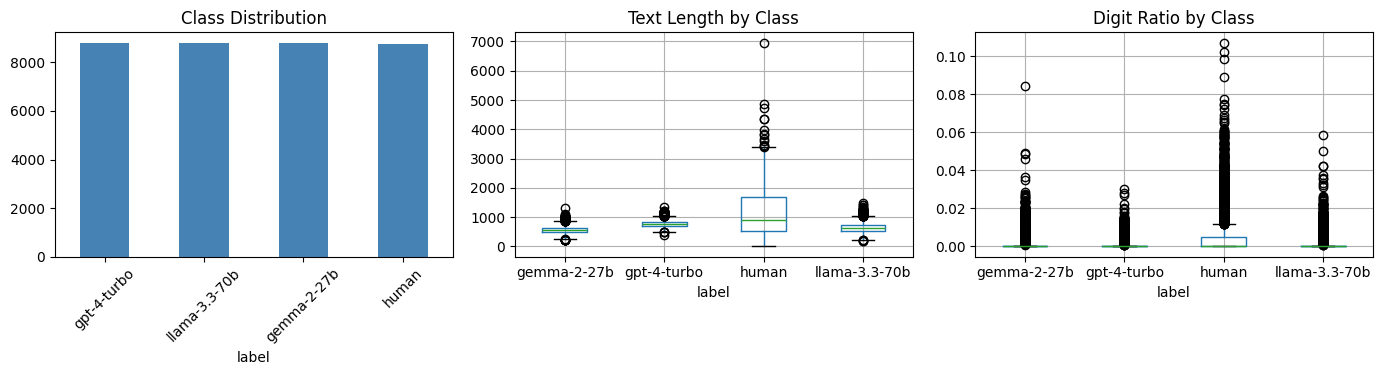

                 mean    std
label                       
gemma-2-27b     558.2  117.0
gpt-4-turbo     764.7  103.6
human          1100.2  671.3
llama-3.3-70b   631.4  159.1


In [4]:
# EDA
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

train_df["label"].value_counts().plot(kind="bar", ax=axes[0], color="steelblue")
axes[0].set_title("Class Distribution")
axes[0].tick_params(axis='x', rotation=45)

train_df["text_len"] = train_df["text"].str.len()
train_df.boxplot(column="text_len", by="label", ax=axes[1])
axes[1].set_title("Text Length by Class")
plt.suptitle("")

train_df["digit_ratio"] = train_df["text"].apply(lambda x: sum(c.isdigit() for c in str(x)) / max(len(str(x)), 1))
train_df.boxplot(column="digit_ratio", by="label", ax=axes[2])
axes[2].set_title("Digit Ratio by Class")
plt.suptitle("")

plt.tight_layout()
plt.savefig("eda.png", dpi=150)
plt.show()

print(train_df.groupby("label")["text_len"].agg(["mean", "std"]).round(1))

## 2. Baselines


TF-IDF - поиск порога для unknown:
  τ=0.3: 0.7691 *
  τ=0.4: 0.7850 *
  τ=0.5: 0.8085 *
  τ=0.6: 0.8106 *
  τ=0.7: 0.7972
  τ=0.8: 0.7444

TF-IDF: 0.7685 → 0.8106 (τ=0.6)
               precision    recall  f1-score   support

        human       0.85      0.91      0.88      2194
  gpt-4-turbo       0.86      0.91      0.89      2205
llama-3.3-70b       0.97      0.90      0.93      2203
  gemma-2-27b       0.80      0.83      0.81      2204
      unknown       0.55      0.51      0.53      2173

     accuracy                           0.81     10979
    macro avg       0.81      0.81      0.81     10979
 weighted avg       0.81      0.81      0.81     10979



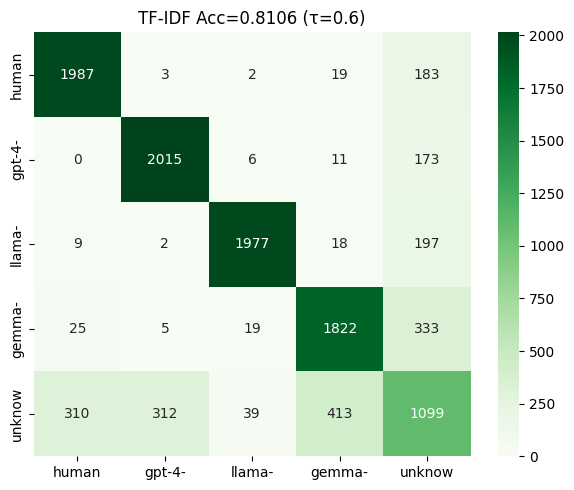

In [5]:
# Baseline 1: TF-IDF + LogReg
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), max_df=0.9, min_df=3)
X_train_tfidf = tfidf.fit_transform(train_df["text"])
X_dev_tfidf = tfidf.transform(dev_df["text"])

clf_tfidf = LogisticRegression(C=1, max_iter=1000, class_weight="balanced", n_jobs=-1, random_state=SEED)
clf_tfidf.fit(X_train_tfidf, train_df["label_id"])

tfidf_probs = clf_tfidf.predict_proba(X_dev_tfidf)
tfidf_pred = tfidf_probs.argmax(-1)
tfidf_acc = accuracy_score(dev_df["label_id"], tfidf_pred)

# Поиск порога для unknown
def find_best_threshold(probs, y_true, name="Model"):
    """Поиск оптимального порога для unknown класса"""
    best_acc, best_t = 0, 0.5
    print(f"\n{name} - поиск порога для unknown:")
    for t in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
        pred = probs.argmax(-1).copy()
        pred[probs.max(-1) < t] = 4  # unknown
        acc = accuracy_score(y_true, pred)
        marker = " *" if acc > best_acc else ""
        print(f"  τ={t}: {acc:.4f}{marker}")
        if acc > best_acc:
            best_acc, best_t = acc, t
    return best_t, best_acc

tfidf_threshold, tfidf_acc_thresh = find_best_threshold(tfidf_probs, dev_df["label_id"].values, "TF-IDF")
tfidf_pred_final = tfidf_probs.argmax(-1).copy()
tfidf_pred_final[tfidf_probs.max(-1) < tfidf_threshold] = 4

print(f"\nTF-IDF: {tfidf_acc:.4f} → {tfidf_acc_thresh:.4f} (τ={tfidf_threshold})")
print(classification_report(dev_df["label_id"], tfidf_pred_final, target_names=[ID2LABEL[i] for i in range(5)]))

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(confusion_matrix(dev_df["label_id"], tfidf_pred_final), annot=True, fmt="d", cmap="Greens", ax=ax,
            xticklabels=[ID2LABEL[i][:6] for i in range(5)], yticklabels=[ID2LABEL[i][:6] for i in range(5)])
ax.set_title(f"TF-IDF Acc={tfidf_acc_thresh:.4f} (τ={tfidf_threshold})")
plt.tight_layout(); plt.savefig("tfidf_cm.png", dpi=150); plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at models/rubert-tiny2_ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
BERT 1/10: 100%|██████████| 550/550 [01:10<00:00,  7.85it/s, loss=0.128, avg=0.149]


[2026-01-14 11:25:45,067] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Ep 1: Loss=0.3775, Acc=0.7753 * (saved)


BERT 2/10: 100%|██████████| 550/550 [01:10<00:00,  7.85it/s, loss=0.110, avg=0.084]


Ep 2: Loss=0.0910, Acc=0.7818 * (saved)


BERT 3/10: 100%|██████████| 550/550 [01:09<00:00,  7.89it/s, loss=0.006, avg=0.054]


Ep 3: Loss=0.0441, Acc=0.7797 (patience 1/3)


BERT 4/10: 100%|██████████| 550/550 [01:09<00:00,  7.91it/s, loss=0.003, avg=0.026]


Ep 4: Loss=0.0269, Acc=0.7805 (patience 2/3)


BERT 5/10: 100%|██████████| 550/550 [01:10<00:00,  7.83it/s, loss=0.002, avg=0.015]


Ep 5: Loss=0.0172, Acc=0.7829 * (saved)


BERT 6/10: 100%|██████████| 550/550 [01:09<00:00,  7.93it/s, loss=0.005, avg=0.016]


Ep 6: Loss=0.0143, Acc=0.7813 (patience 1/3)


BERT 7/10: 100%|██████████| 550/550 [01:10<00:00,  7.80it/s, loss=0.001, avg=0.010]


Ep 7: Loss=0.0083, Acc=0.7807 (patience 2/3)


BERT 8/10: 100%|██████████| 550/550 [01:11<00:00,  7.67it/s, loss=0.004, avg=0.015]


Ep 8: Loss=0.0126, Acc=0.7814 (patience 3/3)
Early stopping at epoch 8

Loaded best model: 0.7829

ruBERT - поиск порога для unknown:
  τ=0.3: 0.7829 *
  τ=0.4: 0.7830 *
  τ=0.5: 0.7847 *
  τ=0.6: 0.7909 *
  τ=0.7: 0.7966 *
  τ=0.8: 0.8029 *

ruBERT: 0.7829 → 0.8029 (τ=0.8)
               precision    recall  f1-score   support

        human       0.80      0.96      0.87      2194
  gpt-4-turbo       0.84      0.99      0.91      2205
llama-3.3-70b       0.94      0.97      0.96      2203
  gemma-2-27b       0.69      0.95      0.80      2204
      unknown       0.69      0.14      0.23      2173

     accuracy                           0.80     10979
    macro avg       0.79      0.80      0.75     10979
 weighted avg       0.79      0.80      0.75     10979



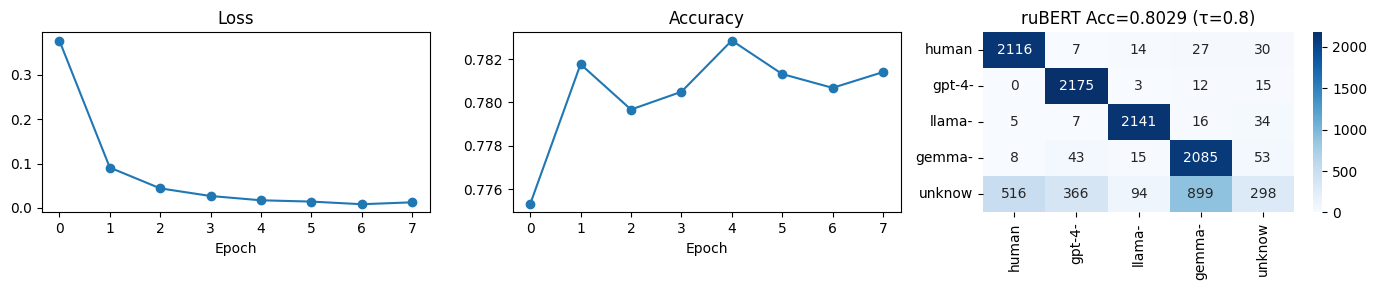

In [6]:
# Baseline 2: ruBERT-tiny fine-tuning
from transformers import AutoModelForSequenceClassification

BERT_MAX_LEN = 384
BERT_SAVE_DIR = Path("checkpoints/rubert_tiny")
BERT_SAVE_DIR.mkdir(parents=True, exist_ok=True)

bert_tokenizer = AutoTokenizer.from_pretrained(str(BERT_PATH))

class BertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=BERT_MAX_LEN):
        self.texts, self.labels, self.tokenizer, self.max_len = texts, labels, tokenizer, max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, idx):
        enc = self.tokenizer(self.texts[idx], truncation=True, max_length=self.max_len, padding="max_length", return_tensors="pt")
        return {"input_ids": enc["input_ids"].squeeze(), "attention_mask": enc["attention_mask"].squeeze(), 
                "labels": torch.tensor(self.labels[idx])}

bert_train_ds = BertDataset(train_df["text"].tolist(), train_df["label_id"].tolist(), bert_tokenizer)
bert_dev_ds = BertDataset(dev_df["text"].tolist(), dev_df["label_id"].tolist(), bert_tokenizer)
bert_model = AutoModelForSequenceClassification.from_pretrained(str(BERT_PATH), num_labels=5).cuda()

bert_loader = DataLoader(bert_train_ds, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
bert_dev_loader = DataLoader(bert_dev_ds, batch_size=128)
bert_opt = AdamW(bert_model.parameters(), lr=5e-5)

BERT_EPOCHS, PATIENCE = 10, 3
bert_history = {"loss": [], "acc": []}
best_bert_acc, patience_cnt = 0, 0

for ep in range(BERT_EPOCHS):
    bert_model.train()
    losses = []
    pbar = tqdm(bert_loader, desc=f"BERT {ep+1}/{BERT_EPOCHS}")
    for batch in pbar:
        bert_opt.zero_grad()
        out = bert_model(input_ids=batch["input_ids"].cuda(), attention_mask=batch["attention_mask"].cuda(), labels=batch["labels"].cuda())
        out.loss.backward()
        bert_opt.step()
        losses.append(out.loss.item())
        pbar.set_postfix({"loss": f"{out.loss.item():.3f}", "avg": f"{np.mean(losses[-50:]):.3f}"})
    bert_history["loss"].append(np.mean(losses))
    
    bert_model.eval()
    correct = sum((bert_model(batch["input_ids"].cuda(), batch["attention_mask"].cuda()).logits.argmax(-1) == batch["labels"].cuda()).sum().item() 
                  for batch in bert_dev_loader)
    acc = correct / len(bert_dev_ds)
    bert_history["acc"].append(acc)
    
    if acc > best_bert_acc:
        best_bert_acc = acc
        patience_cnt = 0
        bert_model.save_pretrained(BERT_SAVE_DIR / "best")
        bert_tokenizer.save_pretrained(BERT_SAVE_DIR / "best")
        print(f"Ep {ep+1}: Loss={bert_history['loss'][-1]:.4f}, Acc={acc:.4f} * (saved)")
    else:
        patience_cnt += 1
        print(f"Ep {ep+1}: Loss={bert_history['loss'][-1]:.4f}, Acc={acc:.4f} (patience {patience_cnt}/{PATIENCE})")
    
    if patience_cnt >= PATIENCE:
        print(f"Early stopping at epoch {ep+1}")
        break

# Load best model
bert_model = AutoModelForSequenceClassification.from_pretrained(BERT_SAVE_DIR / "best").cuda()
print(f"\nLoaded best model: {best_bert_acc:.4f}")

# Final eval with threshold search
bert_model.eval()
bert_logits_list = []
with torch.no_grad():
    for batch in bert_dev_loader:
        logits = bert_model(batch["input_ids"].cuda(), batch["attention_mask"].cuda()).logits
        bert_logits_list.append(logits.cpu())
bert_logits = torch.cat(bert_logits_list)
bert_probs = F.softmax(bert_logits, dim=-1).numpy()

bert_acc = best_bert_acc
bert_threshold, bert_acc_thresh = find_best_threshold(bert_probs, dev_df["label_id"].values, "ruBERT")
bert_pred_final = bert_probs.argmax(-1).copy()
bert_pred_final[bert_probs.max(-1) < bert_threshold] = 4

print(f"\nruBERT: {bert_acc:.4f} → {bert_acc_thresh:.4f} (τ={bert_threshold})")
print(classification_report(dev_df["label_id"], bert_pred_final, target_names=[ID2LABEL[i] for i in range(5)]))

fig, axes = plt.subplots(1, 3, figsize=(14, 3))
axes[0].plot(bert_history["loss"], marker='o'); axes[0].set_title("Loss"); axes[0].set_xlabel("Epoch")
axes[1].plot(bert_history["acc"], marker='o'); axes[1].set_title("Accuracy"); axes[1].set_xlabel("Epoch")
sns.heatmap(confusion_matrix(dev_df["label_id"], bert_pred_final), annot=True, fmt="d", cmap="Blues", ax=axes[2],
            xticklabels=[ID2LABEL[i][:6] for i in range(5)], yticklabels=[ID2LABEL[i][:6] for i in range(5)])
axes[2].set_title(f"ruBERT Acc={bert_acc_thresh:.4f} (τ={bert_threshold})")
plt.tight_layout(); plt.savefig("bert_training.png", dpi=150); plt.show()

## 3. Main Model: Qwen + Dual-Head (EOS pooling)

In [7]:
# Dataset with augmentation + dual labels
class DualHeadDataset(Dataset):
    def __init__(self, texts, binary_labels, multi_labels, label_ids, tokenizer, max_len=512, min_len=64, augment=True):
        self.texts = texts
        self.binary_labels = [int(l) for l in binary_labels]
        self.multi_labels = [int(l) for l in multi_labels]  # -1 for human
        self.label_ids = [int(l) for l in label_ids]  # original 5-class
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.min_len = min_len
        self.augment = augment
        self.pad_id = tokenizer.pad_token_id
        self.eos_id = tokenizer.eos_token_id

    def __len__(self): 
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx] if self.texts[idx] else ""
        tokens = self.tokenizer.encode(text, add_special_tokens=False)
        
        if len(tokens) == 0:
            tokens = [self.eos_id]
        
        if self.augment and len(tokens) > self.min_len:
            tgt_len = random.randint(min(self.min_len, len(tokens)), min(len(tokens), self.max_len - 1))
            if len(tokens) > tgt_len:
                start = random.randint(0, len(tokens) - tgt_len)
                tokens = tokens[start:start + tgt_len]
        else:
            tokens = tokens[:self.max_len - 1]
        
        tokens = tokens + [self.eos_id]
        attn = [1] * len(tokens)
        pad_len = self.max_len - len(tokens)
        tokens = [self.pad_id] * pad_len + tokens
        attn = [0] * pad_len + attn
        
        return {
            "input_ids": torch.LongTensor(tokens), 
            "attention_mask": torch.LongTensor(attn),
            "binary_label": torch.tensor(self.binary_labels[idx], dtype=torch.long),
            "multi_label": torch.tensor(self.multi_labels[idx], dtype=torch.long),
            "label_id": torch.tensor(self.label_ids[idx], dtype=torch.long)
        }

In [8]:
# Model with Dual Head (EOS pooling like GigaCheck)
class QwenDualHead(nn.Module):
    """
    Dual-Head Architecture (как в GigaCheck):
    - Head 1: Binary classification (human=0 vs AI=1)
    - Head 2: Multiclass (gpt-4=0, llama=1, gemma=2, unknown=3)
    
    Pooling: EOS token only (как в GigaCheck)
    
    Inference: 
    1. Если binary=0 → human
    2. Если binary=1 → используем multiclass для определения какой AI
    """
    def __init__(self, model_path, num_multi_classes=4):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_path, torch_dtype=torch.bfloat16)
        hs = self.backbone.config.hidden_size
        self.pad_id = self.backbone.config.pad_token_id
        
        # Shared representation layer (как в GigaCheck: 2 linear layers)
        self.shared = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(hs, hs),
            nn.Tanh(),
            nn.Dropout(0.1)
        ).to(torch.bfloat16)
        
        # Head 1: Binary (human vs AI)
        self.binary_head = nn.Linear(hs, 2).to(torch.bfloat16)
        
        # Head 2: Multiclass (which AI model)
        self.multi_head = nn.Linear(hs, num_multi_classes).to(torch.bfloat16)
    
    def forward(self, input_ids, attention_mask):
        h = self.backbone(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        
        # EOS pooling: последний токен (left padding, так что это последняя позиция)
        eos = h[:, -1, :]
        
        shared = self.shared(eos)
        binary_logits = self.binary_head(shared)  # [B, 2]
        multi_logits = self.multi_head(shared)    # [B, 4]
        
        return binary_logits, multi_logits
    
    def predict(self, input_ids, attention_mask):
        """
        Inference: combine binary and multiclass predictions
        Returns: 5-class labels (human=0, gpt=1, llama=2, gemma=3, unknown=4)
        """
        binary_logits, multi_logits = self.forward(input_ids, attention_mask)
        
        binary_pred = binary_logits.argmax(-1)  # 0=human, 1=AI
        multi_pred = multi_logits.argmax(-1)    # 0=gpt, 1=llama, 2=gemma, 3=unknown
        
        # Combine: if human → 0, if AI → multi_pred + 1
        final_pred = torch.where(binary_pred == 0, 
                                  torch.zeros_like(binary_pred),  # human=0
                                  multi_pred + 1)  # AI classes: 1,2,3,4
        return final_pred, binary_pred, multi_pred

print("Dual-Head Model (EOS pooling) defined")

Dual-Head Model (EOS pooling) defined


In [9]:
# Init
tokenizer = AutoTokenizer.from_pretrained(str(QWEN_PATH))
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

model = QwenDualHead(str(QWEN_PATH), num_multi_classes=4)
model.pad_id = tokenizer.pad_token_id
model.backbone.gradient_checkpointing_enable()

lora_cfg = LoraConfig(r=8, lora_alpha=16, target_modules=["q_proj", "v_proj"], lora_dropout=0.1, bias="none")
model.backbone = get_peft_model(model.backbone, lora_cfg)
model.backbone.print_trainable_parameters()

model = model.cuda()
print(f"VRAM: {torch.cuda.memory_allocated() / 1e9:.1f} GB")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

trainable params: 2,523,136 || all params: 7,073,142,272 || trainable%: 0.0357
VRAM: 14.8 GB


In [10]:
# Datasets
MAX_LEN, MIN_LEN = 512, 64

train_ds = DualHeadDataset(
    train_df["text"].tolist(), 
    train_df["binary_id"].tolist(),
    train_df["multi_id"].tolist(),
    train_df["label_id"].tolist(),
    tokenizer, MAX_LEN, MIN_LEN, True
)

dev_ds = DualHeadDataset(
    dev_df["text"].tolist(),
    dev_df["binary_id"].tolist(), 
    dev_df["multi_id"].tolist(),
    dev_df["label_id"].tolist(),
    tokenizer, MAX_LEN, MIN_LEN, False
)

# Binary class weights
binary_counts = train_df["binary_id"].value_counts()
binary_w = np.array([1.0 / binary_counts[0], 1.0 / binary_counts[1]])
binary_w = binary_w / binary_w.sum() * 2
binary_weights = torch.tensor(binary_w, dtype=torch.float32, device="cuda")

# Multiclass weights (только AI классы)
multi_counts = train_df[train_df["multi_id"] >= 0]["multi_id"].value_counts()
multi_w = []
for i in range(4):
    if i in multi_counts.index:
        multi_w.append(1.0 / multi_counts[i])
    else:
        multi_w.append(1.0)  # для unknown
multi_w = np.array(multi_w)
multi_w = multi_w / multi_w.sum() * 4
multi_weights = torch.tensor(multi_w, dtype=torch.float32, device="cuda")

print(f"Train: {len(train_ds)}, Dev: {len(dev_ds)}")
print(f"Binary weights: {binary_weights}")
print(f"Multi weights: {multi_weights}")

Train: 35158, Dev: 10979
Binary weights: tensor([1.5012, 0.4988], device='cuda:0')
Multi weights: tensor([4.5434e-04, 4.5449e-04, 4.5491e-04, 3.9986e+00], device='cuda:0')


In [11]:
# Training with Dual Loss + Early Stopping
# A100 40GB: максимальный batch size
BS, ACCUM, LR, EPOCHS, PATIENCE = 16, 1, 3e-5, 10, 3  # effective batch = 16, ~2200 steps/epoch

train_loader = DataLoader(train_ds, batch_size=BS, shuffle=True, num_workers=0, pin_memory=True)
dev_loader = DataLoader(dev_ds, batch_size=32, num_workers=0)

binary_criterion = nn.CrossEntropyLoss(weight=binary_weights)
multi_criterion = nn.CrossEntropyLoss(weight=multi_weights, ignore_index=-1)

optimizer = AdamW([
    {"params": model.backbone.parameters(), "lr": LR},
    {"params": model.shared.parameters(), "lr": LR*2},
    {"params": model.binary_head.parameters(), "lr": LR*2},
    {"params": model.multi_head.parameters(), "lr": LR*2}
], weight_decay=0.01)

total_steps = len(train_loader) * EPOCHS
scheduler = get_cosine_schedule_with_warmup(optimizer, int(total_steps * 0.1), total_steps)

best_acc, patience_cnt = 0, 0
history = {"loss": [], "acc": []}

for epoch in range(EPOCHS):
    model.train()
    ep_loss = []
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for step, batch in enumerate(pbar):
        optimizer.zero_grad()
        
        # Forward в bfloat16
        with torch.amp.autocast('cuda', dtype=torch.bfloat16):
            binary_logits, multi_logits = model(batch["input_ids"].cuda(), batch["attention_mask"].cuda())
        
        # Loss в float32
        loss_bin = binary_criterion(binary_logits.float(), batch["binary_label"].cuda())
        
        # Multiclass loss только если есть AI samples в батче
        multi_labels = batch["multi_label"].cuda()
        if (multi_labels >= 0).any():
            loss_multi = multi_criterion(multi_logits.float(), multi_labels)
            loss = loss_bin + loss_multi
        else:
            loss = loss_bin
            
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        ep_loss.append(loss.item())
        pbar.set_postfix({"loss": f"{loss.item():.3f}"})
    
    avg_loss = np.mean(ep_loss)
    history["loss"].append(avg_loss)
    
    # Eval
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in dev_loader:
            with torch.amp.autocast('cuda', dtype=torch.bfloat16):
                final_pred, _, _ = model.predict(batch["input_ids"].cuda(), batch["attention_mask"].cuda())
            preds.extend(final_pred.cpu().tolist())
            trues.extend(batch["label_id"].tolist())
    acc = accuracy_score(trues, preds)
    history["acc"].append(acc)
    
    print(f"Epoch {epoch+1}: Loss={avg_loss:.4f}, Acc={acc:.4f}", end="")
    if acc > best_acc:
        best_acc = acc
        patience_cnt = 0
        torch.save({
            "backbone": model.backbone.state_dict(),
            "shared": model.shared.state_dict(),
            "binary_head": model.binary_head.state_dict(),
            "multi_head": model.multi_head.state_dict()
        }, SAVE_DIR / "best.pt")
        print("  Best!")
    else:
        patience_cnt += 1
        print(f"  (patience {patience_cnt}/{PATIENCE})")
    
    if patience_cnt >= PATIENCE:
        print(f"Early stopping at epoch {epoch+1}")
        break

# Load best
ckpt = torch.load(SAVE_DIR / "best.pt")
model.backbone.load_state_dict(ckpt["backbone"])
model.shared.load_state_dict(ckpt["shared"])
model.binary_head.load_state_dict(ckpt["binary_head"])
model.multi_head.load_state_dict(ckpt["multi_head"])
print(f"\nDone! Best: {best_acc:.4f}")

Epoch 1: 100%|██████████| 2198/2198 [1:19:27<00:00,  2.17s/it, loss=0.844]


Epoch 1: Loss=0.9376, Acc=0.7753  Best!


Epoch 2: 100%|██████████| 2198/2198 [1:19:32<00:00,  2.17s/it, loss=0.001]


Epoch 2: Loss=0.2981, Acc=0.7873  Best!


Epoch 3: 100%|██████████| 2198/2198 [1:19:36<00:00,  2.17s/it, loss=0.021]


Epoch 3: Loss=0.2292, Acc=0.7908  Best!


Epoch 4: 100%|██████████| 2198/2198 [1:19:33<00:00,  2.17s/it, loss=0.020]


Epoch 4: Loss=0.1933, Acc=0.7919  Best!


Epoch 5: 100%|██████████| 2198/2198 [1:19:36<00:00,  2.17s/it, loss=0.016]


Epoch 5: Loss=0.1644, Acc=0.7901  (patience 1/3)


Epoch 6: 100%|██████████| 2198/2198 [1:19:33<00:00,  2.17s/it, loss=0.001]


Epoch 6: Loss=0.1540, Acc=0.7940  Best!


Epoch 7: 100%|██████████| 2198/2198 [1:19:36<00:00,  2.17s/it, loss=0.047]


Epoch 7: Loss=0.1460, Acc=0.7943  Best!


Epoch 8: 100%|██████████| 2198/2198 [1:19:36<00:00,  2.17s/it, loss=0.000]


Epoch 8: Loss=0.1394, Acc=0.7942  (patience 1/3)


Epoch 9: 100%|██████████| 2198/2198 [1:19:35<00:00,  2.17s/it, loss=0.510]


Epoch 9: Loss=0.1335, Acc=0.7953  Best!


Epoch 10: 100%|██████████| 2198/2198 [1:19:37<00:00,  2.17s/it, loss=0.001]


Epoch 10: Loss=0.1362, Acc=0.7952  (patience 1/3)

Done! Best: 0.7953


In [ ]:
# Eval Qwen with Energy Score for unknown detection

# === Setup (skip training cell) ===
dev_loader = DataLoader(dev_ds, batch_size=32, num_workers=0)

# === Load pre-trained model ===
CHECKPOINT_PATH = SAVE_DIR / "best.pt"
if CHECKPOINT_PATH.exists():
    print(f"Loading checkpoint from {CHECKPOINT_PATH}...")
    ckpt = torch.load(CHECKPOINT_PATH, map_location="cuda")
    model.backbone.load_state_dict(ckpt["backbone"])
    model.shared.load_state_dict(ckpt["shared"])
    model.binary_head.load_state_dict(ckpt["binary_head"])
    model.multi_head.load_state_dict(ckpt["multi_head"])
    print("Checkpoint loaded!")
else:
    print(f"WARNING: Checkpoint not found at {CHECKPOINT_PATH}, using current model state")

model.eval()
all_preds, all_binary, all_logits, all_probs = [], [], [], []

with torch.no_grad():
    for batch in tqdm(dev_loader, desc="Eval"):
        with torch.amp.autocast('cuda', dtype=torch.bfloat16):
            bin_log, multi_log = model(batch["input_ids"].cuda(), batch["attention_mask"].cuda())
            
            # Combine into 5-class logits (для Energy Score)
            combined_logits = torch.zeros(bin_log.shape[0], 5, device=bin_log.device)
            combined_logits[:, 0] = bin_log[:, 0]  # human logit
            combined_logits[:, 1:] = multi_log + bin_log[:, 1:2]  # AI logits
            
            # Probs для сравнения
            probs = F.softmax(combined_logits.float(), dim=-1)
            
            final_pred, binary_pred, _ = model.predict(batch["input_ids"].cuda(), batch["attention_mask"].cuda())
        
        all_preds.extend(final_pred.cpu().tolist())
        all_binary.extend(binary_pred.cpu().tolist())
        all_logits.append(combined_logits.float().cpu())
        all_probs.append(probs.float().cpu())

y_pred, y_true = np.array(all_preds), dev_df["label_id"].values
y_binary_pred, y_binary_true = np.array(all_binary), dev_df["binary_id"].values
qwen_logits = torch.cat(all_logits)
qwen_probs = torch.cat(all_probs).numpy()

# === 1. Baseline: без threshold ===
qwen_acc_base = accuracy_score(y_true, y_pred)
print(f"Qwen Base (no threshold): {qwen_acc_base:.4f}")

# === 2. Softmax Confidence threshold (старый метод) ===
def find_best_confidence_threshold(probs, y_true):
    best_acc, best_t = 0, 0.5
    print("\nSoftmax Confidence threshold:")
    for t in [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
        pred = probs.argmax(-1).copy()
        pred[probs.max(-1) < t] = 4
        acc = accuracy_score(y_true, pred)
        marker = " *" if acc > best_acc else ""
        print(f"  τ={t}: {acc:.4f}{marker}")
        if acc > best_acc:
            best_acc, best_t = acc, t
    return best_t, best_acc

conf_threshold, conf_acc = find_best_confidence_threshold(qwen_probs, y_true)

# === 3. Energy Score (новый метод) ===
def find_best_energy_threshold(logits, y_true):
    """
    Energy Score (Liu et al., 2020): E(x) = -logsumexp(logits)
    Низкая energy = известный класс, высокая = unknown (OOD)
    """
    energy = -torch.logsumexp(logits, dim=-1).numpy()
    pred_base = logits.argmax(dim=-1).numpy()
    
    best_acc, best_t = 0, 0
    print("\nEnergy Score threshold:")
    
    # Поиск по перцентилям energy
    for p in [50, 60, 70, 80, 85, 90, 95]:
        t = np.percentile(energy, p)
        pred = pred_base.copy()
        pred[energy > t] = 4
        acc = accuracy_score(y_true, pred)
        marker = " *" if acc > best_acc else ""
        print(f"  p={p}% (τ={t:.2f}): {acc:.4f}{marker}")
        if acc > best_acc:
            best_acc, best_t = acc, t
    
    return best_t, best_acc

energy_threshold, energy_acc = find_best_energy_threshold(qwen_logits, y_true)

# === 4. Комбинация: Energy + Confidence ===
def find_best_combined_threshold(logits, probs, y_true):
    """Комбинация Energy Score и Confidence"""
    energy = -torch.logsumexp(logits, dim=-1).numpy()
    max_prob = probs.max(-1)
    pred_base = logits.argmax(dim=-1).numpy()
    
    best_acc, best_params = 0, (0, 0)
    print("\nCombined (Energy + Confidence):")
    
    for e_p in [70, 80, 90]:
        e_t = np.percentile(energy, e_p)
        for c_t in [0.4, 0.5, 0.6]:
            pred = pred_base.copy()
            # Unknown если: высокая energy ИЛИ низкая confidence
            is_unknown = (energy > e_t) | (max_prob < c_t)
            pred[is_unknown] = 4
            acc = accuracy_score(y_true, pred)
            marker = " *" if acc > best_acc else ""
            if acc > best_acc:
                best_acc = acc
                best_params = (e_t, c_t)
                print(f"  energy_p={e_p}%, conf={c_t}: {acc:.4f}{marker}")
    
    return best_params, best_acc

combined_params, combined_acc = find_best_combined_threshold(qwen_logits, qwen_probs, y_true)

# === Итоговое сравнение ===
print("\n" + "="*50)
print("UNKNOWN DETECTION COMPARISON:")
print("="*50)
print(f"  Base (no threshold):    {qwen_acc_base:.4f}")
print(f"  Softmax Confidence:     {conf_acc:.4f} (τ={conf_threshold})")
print(f"  Energy Score:           {energy_acc:.4f} (τ={energy_threshold:.2f})")
print(f"  Combined:               {combined_acc:.4f} (e={combined_params[0]:.2f}, c={combined_params[1]})")
print("="*50)

# Лучший метод
best_method = max([
    ("Base", qwen_acc_base, None),
    ("Confidence", conf_acc, conf_threshold),
    ("Energy", energy_acc, energy_threshold),
    ("Combined", combined_acc, combined_params)
], key=lambda x: x[1])

print(f"\nBest method: {best_method[0]} with acc={best_method[1]:.4f}")

# Финальные предсказания лучшим методом
if best_method[0] == "Energy":
    energy = -torch.logsumexp(qwen_logits, dim=-1).numpy()
    qwen_pred_final = qwen_logits.argmax(dim=-1).numpy()
    qwen_pred_final[energy > energy_threshold] = 4
elif best_method[0] == "Combined":
    energy = -torch.logsumexp(qwen_logits, dim=-1).numpy()
    qwen_pred_final = qwen_logits.argmax(dim=-1).numpy()
    is_unknown = (energy > combined_params[0]) | (qwen_probs.max(-1) < combined_params[1])
    qwen_pred_final[is_unknown] = 4
elif best_method[0] == "Confidence":
    qwen_pred_final = qwen_probs.argmax(-1).copy()
    qwen_pred_final[qwen_probs.max(-1) < conf_threshold] = 4
else:
    qwen_pred_final = y_pred

qwen_acc_final = accuracy_score(y_true, qwen_pred_final)
print(f"\nFinal Qwen Accuracy: {qwen_acc_final:.4f}")
print(f"Binary Accuracy: {accuracy_score(y_binary_true, y_binary_pred):.4f}")
print(classification_report(y_true, qwen_pred_final, target_names=[ID2LABEL[i] for i in range(5)]))

In [18]:
# === Mahalanobis Distance для OOD Detection ===
# Шаг 1: Собираем эмбеддинги train (output shared layer)

print("Collecting train embeddings for Mahalanobis...")
model.eval()

# Создаём train loader БЕЗ augmentation для стабильных эмбеддингов
train_ds_no_aug = DualHeadDataset(
    train_df["text"].tolist(), 
    train_df["binary_id"].tolist(),
    train_df["multi_id"].tolist(),
    train_df["label_id"].tolist(),
    tokenizer, MAX_LEN, MIN_LEN, augment=False  # БЕЗ аугментации!
)
train_loader_emb = DataLoader(train_ds_no_aug, batch_size=32, shuffle=False, num_workers=0)

train_embeddings = []
train_labels = []

with torch.no_grad():
    for batch in tqdm(train_loader_emb, desc="Train embeddings"):
        with torch.amp.autocast('cuda', dtype=torch.bfloat16):
            h = model.backbone(input_ids=batch["input_ids"].cuda(), 
                              attention_mask=batch["attention_mask"].cuda()).last_hidden_state
            eos = h[:, -1, :]  # EOS pooling
            shared_out = model.shared(eos)  # output shared layer
        
        train_embeddings.append(shared_out.float().cpu())
        train_labels.extend(batch["label_id"].tolist())

train_embeddings = torch.cat(train_embeddings)  # [N_train, hidden_size]
train_labels = np.array(train_labels)

print(f"Train embeddings: {train_embeddings.shape}")
print(f"Classes in train: {np.unique(train_labels)}")  # должно быть [0,1,2,3] без 4 (unknown)

Train embeddings: 100%|██████████| 1099/1099 [25:01<00:00,  1.37s/it]


Train embeddings: torch.Size([35158, 3584])
Classes in train: [0 1 2 3]


In [20]:
# Шаг 2: Вычисляем mean и covariance для каждого класса
from scipy.spatial.distance import mahalanobis

# Центры классов (только 4 класса из train, без unknown)
class_means = {}
for c in [0, 1, 2, 3]:  # human, gpt, llama, gemma
    mask = train_labels == c
    class_means[c] = train_embeddings[mask].mean(dim=0).numpy()
    print(f"Class {c} ({ID2LABEL[c]}): {mask.sum()} samples")

# Tied covariance (общая для всех классов - более стабильно)
all_centered = []
for c in [0, 1, 2, 3]:
    mask = train_labels == c
    centered = train_embeddings[mask].numpy() - class_means[c]
    all_centered.append(centered)
all_centered = np.vstack(all_centered)

# Регуляризация для численной стабильности
cov_matrix = np.cov(all_centered, rowvar=False)
cov_matrix += np.eye(cov_matrix.shape[0]) * 1e-5  # регуляризация
cov_inv = np.linalg.inv(cov_matrix)

print(f"\nCovariance matrix: {cov_matrix.shape}")
# print(f"Condition number: {np.linalg.cond(cov_matrix):.2e}")

Class 0 (human): 8769 samples
Class 1 (gpt-4-turbo): 8801 samples
Class 2 (llama-3.3-70b): 8798 samples
Class 3 (gemma-2-27b): 8790 samples

Covariance matrix: (3584, 3584)


In [21]:
# Шаг 3: Собираем эмбеддинги dev и вычисляем Mahalanobis distance
print("Collecting dev embeddings...")

dev_embeddings = []
with torch.no_grad():
    for batch in tqdm(dev_loader, desc="Dev embeddings"):
        with torch.amp.autocast('cuda', dtype=torch.bfloat16):
            h = model.backbone(input_ids=batch["input_ids"].cuda(), 
                              attention_mask=batch["attention_mask"].cuda()).last_hidden_state
            eos = h[:, -1, :]
            shared_out = model.shared(eos)
        dev_embeddings.append(shared_out.float().cpu())

dev_embeddings = torch.cat(dev_embeddings).numpy()  # [N_dev, hidden_size]
print(f"Dev embeddings: {dev_embeddings.shape}")

# Вычисляем Mahalanobis distance до каждого класса
print("\nComputing Mahalanobis distances...")
maha_distances = np.zeros((len(dev_embeddings), 4))  # расстояния до 4 классов

for i, emb in enumerate(tqdm(dev_embeddings, desc="Mahalanobis")):
    for c in [0, 1, 2, 3]:
        maha_distances[i, c] = mahalanobis(emb, class_means[c], cov_inv)

# OOD score = минимальное расстояние (чем больше, тем более OOD)
min_maha_dist = maha_distances.min(axis=1)
maha_pred_class = maha_distances.argmin(axis=1)  # предсказание по ближайшему классу

print(f"\nMahalanobis distances stats:")
print(f"  Min: {min_maha_dist.min():.2f}, Max: {min_maha_dist.max():.2f}")
print(f"  Mean: {min_maha_dist.mean():.2f}, Std: {min_maha_dist.std():.2f}")

Dev embeddings: 100%|██████████| 344/344 [07:48<00:00,  1.36s/it]


Dev embeddings: (10979, 3584)

Computing Mahalanobis distances...


Mahalanobis: 100%|██████████| 10979/10979 [40:01<00:00,  4.57it/s] 


Mahalanobis distances stats:
  Min: 37.70, Max: 778.09
  Mean: 66.57, Std: 14.45


In [22]:
# Шаг 4: Поиск оптимального threshold для Mahalanobis
def find_best_mahalanobis_threshold(maha_dist, maha_pred, y_true):
    """
    Если min_distance > threshold → unknown (OOD)
    Иначе → предсказание по ближайшему классу
    """
    best_acc, best_t = 0, 0
    print("\nMahalanobis threshold search:")
    
    # Поиск по перцентилям
    for p in [50, 60, 70, 80, 85, 90, 95, 99]:
        t = np.percentile(maha_dist, p)
        pred = maha_pred.copy()
        pred[maha_dist > t] = 4  # unknown
        acc = accuracy_score(y_true, pred)
        
        # Подсчёт unknown
        n_unknown = (maha_dist > t).sum()
        marker = " *" if acc > best_acc else ""
        print(f"  p={p}% (τ={t:.2f}): {acc:.4f}, unknown={n_unknown}{marker}")
        
        if acc > best_acc:
            best_acc, best_t = acc, t
    
    return best_t, best_acc

maha_threshold, maha_acc = find_best_mahalanobis_threshold(min_maha_dist, maha_pred_class, y_true)

# Финальные предсказания Mahalanobis
maha_pred_final = maha_pred_class.copy()
maha_pred_final[min_maha_dist > maha_threshold] = 4

print(f"\nMahalanobis Accuracy: {maha_acc:.4f} (τ={maha_threshold:.2f})")
print(classification_report(y_true, maha_pred_final, target_names=[ID2LABEL[i] for i in range(5)]))

# === ИТОГОВОЕ СРАВНЕНИЕ ВСЕХ МЕТОДОВ ===
print("\n" + "="*60)
print("FINAL COMPARISON - ALL OOD DETECTION METHODS:")
print("="*60)
print(f"  Base (no threshold):    {qwen_acc_base:.4f}")
print(f"  Softmax Confidence:     {conf_acc:.4f} (τ={conf_threshold})")
print(f"  Energy Score:           {energy_acc:.4f} (τ={energy_threshold:.2f})")
print(f"  Combined (E+C):         {combined_acc:.4f}")
print(f"  Mahalanobis:            {maha_acc:.4f} (τ={maha_threshold:.2f})")
print("="*60)

# Лучший метод
all_methods = [
    ("Base", qwen_acc_base, None),
    ("Confidence", conf_acc, conf_threshold),
    ("Energy", energy_acc, energy_threshold),
    ("Combined", combined_acc, combined_params),
    ("Mahalanobis", maha_acc, maha_threshold)
]
best_overall = max(all_methods, key=lambda x: x[1])
print(f"\nBEST METHOD: {best_overall[0]} with acc={best_overall[1]:.4f}")

# Unknown recall для лучшего метода
if best_overall[0] == "Mahalanobis":
    final_pred = maha_pred_final
else:
    final_pred = qwen_pred_final
    
unknown_mask = y_true == 4
unknown_recall = (final_pred[unknown_mask] == 4).mean()
print(f"Unknown recall: {unknown_recall:.4f} ({(final_pred[unknown_mask] == 4).sum()}/{unknown_mask.sum()})")


Mahalanobis threshold search:
  p=50% (τ=64.54): 0.6885, unknown=5489 *
  p=60% (τ=67.66): 0.7818, unknown=4392 *
  p=70% (τ=71.81): 0.8613, unknown=3294 *
  p=80% (τ=77.49): 0.8997, unknown=2196 *
  p=85% (τ=80.78): 0.8895, unknown=1647
  p=90% (τ=83.91): 0.8642, unknown=1098
  p=95% (τ=88.15): 0.8292, unknown=549
  p=99% (τ=97.80): 0.7987, unknown=110

Mahalanobis Accuracy: 0.8997 (τ=77.49)
               precision    recall  f1-score   support

        human       0.94      0.96      0.95      2194
  gpt-4-turbo       0.89      0.92      0.91      2205
llama-3.3-70b       0.98      0.94      0.96      2203
  gemma-2-27b       0.94      0.91      0.92      2204
      unknown       0.75      0.76      0.76      2173

     accuracy                           0.90     10979
    macro avg       0.90      0.90      0.90     10979
 weighted avg       0.90      0.90      0.90     10979


FINAL COMPARISON - ALL OOD DETECTION METHODS:
  Base (no threshold):    0.7953
  Softmax Confidence:    

In [ ]:
# Визуализация Mahalanobis
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Confusion Matrix для Mahalanobis
sns.heatmap(confusion_matrix(y_true, maha_pred_final), annot=True, fmt="d", cmap="Greens", ax=axes[0],
            xticklabels=[ID2LABEL[i][:6] for i in range(5)], yticklabels=[ID2LABEL[i][:6] for i in range(5)])
axes[0].set_title(f"Mahalanobis Acc={maha_acc:.4f}")

# 2. Распределение Mahalanobis distance по классам
for c in range(5):
    mask = y_true == c
    axes[1].hist(min_maha_dist[mask], bins=50, alpha=0.5, label=ID2LABEL[c][:6])
axes[1].axvline(maha_threshold, color='red', linestyle='--', label=f'τ={maha_threshold:.1f}')
axes[1].set_xlabel("Min Mahalanobis Distance")
axes[1].set_ylabel("Count")
axes[1].set_title("Distance Distribution by Class")
axes[1].legend()
axes[1].set_xlim(30, 120)

# 3. Сравнение методов (bar chart)
methods = ["Base", "Confidence", "Energy", "Combined", "Mahalanobis"]
accs = [qwen_acc_base, conf_acc, energy_acc, combined_acc, maha_acc]
colors = ['gray', 'blue', 'orange', 'purple', 'green']
bars = axes[2].bar(methods, accs, color=colors)
axes[2].set_ylabel("Accuracy")
axes[2].set_title("OOD Detection Methods Comparison")
axes[2].set_ylim(0.75, 1)
for bar, acc in zip(bars, accs):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                 f'{acc:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("mahalanobis_comparison.png", dpi=150)
plt.show()

## 4. Knowledge Distillation

In [15]:
# Генерация soft labels от Teacher (Qwen)
model.eval()
teacher_logits_list = []
with torch.no_grad():
    for batch in tqdm(DataLoader(train_ds, batch_size=8, num_workers=0), desc="Teacher"):
        with torch.amp.autocast('cuda', dtype=torch.bfloat16):
            bin_log, multi_log = model(batch["input_ids"].cuda(), batch["attention_mask"].cuda())
            combined = torch.zeros(bin_log.shape[0], 5, device=bin_log.device)
            combined[:, 0], combined[:, 1:] = bin_log[:, 0], multi_log + bin_log[:, 1:2]
        teacher_logits_list.append(combined.float().cpu())
teacher_logits = torch.cat(teacher_logits_list)
print(f"Teacher logits: {teacher_logits.shape}")

Teacher: 100%|██████████| 4395/4395 [26:06<00:00,  2.81it/s]

Teacher logits: torch.Size([35158, 5])


In [29]:
# Distillation: сравнение двух подходов
TEMP, ALPHA, DIST_EPOCHS = 4.0, 0.7, 5

# ВАЖНО: loader БЕЗ shuffle для соответствия teacher_logits
bert_loader_ordered = DataLoader(bert_train_ds, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

def distill_student(student, name):
    opt = AdamW(student.parameters(), lr=2e-5)
    history = {"loss": [], "acc": []}
    for ep in range(DIST_EPOCHS):
        student.train()
        losses = []
        pbar = tqdm(bert_loader_ordered, desc=f"{name} {ep+1}/{DIST_EPOCHS}")
        for i, batch in enumerate(pbar):
            logits = student(batch["input_ids"].cuda(), batch["attention_mask"].cuda()).logits
            t_logits = teacher_logits[i*64 : i*64+len(logits)].cuda()
            loss_kl = F.kl_div(F.log_softmax(logits/TEMP, -1), F.softmax(t_logits/TEMP, -1), reduction="batchmean") * TEMP**2
            loss = ALPHA * loss_kl + (1-ALPHA) * F.cross_entropy(logits, batch["labels"].cuda())
            opt.zero_grad(); loss.backward(); opt.step()
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.3f}", "avg": f"{np.mean(losses[-50:]):.3f}"})
        history["loss"].append(np.mean(losses))
        student.eval()
        correct = sum((student(b["input_ids"].cuda(), b["attention_mask"].cuda()).logits.argmax(-1) == b["labels"].cuda()).sum().item() for b in bert_dev_loader)
        history["acc"].append(correct / len(bert_dev_ds))
        print(f"  Ep {ep+1}: Loss={history['loss'][-1]:.4f}, Acc={history['acc'][-1]:.4f}")
    return history

# 1. Свежий BERT + KD
print("=== Fresh BERT + Distillation ===")
student_fresh = AutoModelForSequenceClassification.from_pretrained(str(BERT_PATH), num_labels=5).cuda()
hist_fresh = distill_student(student_fresh, "Fresh")

# 2. Fine-tuned BERT + KD  
print("\n=== Fine-tuned BERT + Distillation ===")
bert_model_ft = AutoModelForSequenceClassification.from_pretrained(BERT_SAVE_DIR / "best").cuda()
hist_finetuned = distill_student(bert_model_ft, "FT")

=== Fresh BERT + Distillation ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at models/rubert-tiny2_ and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fresh 1/5: 100%|██████████| 550/550 [01:12<00:00,  7.55it/s, loss=6.732, avg=8.605]  


  Ep 1: Loss=9.8806, Acc=0.4818


Fresh 2/5: 100%|██████████| 550/550 [01:10<00:00,  7.85it/s, loss=3.390, avg=5.316] 


  Ep 2: Loss=6.9786, Acc=0.6271


Fresh 3/5: 100%|██████████| 550/550 [01:09<00:00,  7.95it/s, loss=2.230, avg=3.439]


  Ep 3: Loss=4.5574, Acc=0.6774


Fresh 4/5: 100%|██████████| 550/550 [01:11<00:00,  7.67it/s, loss=1.652, avg=2.292]


  Ep 4: Loss=3.0868, Acc=0.7237


Fresh 5/5: 100%|██████████| 550/550 [01:10<00:00,  7.76it/s, loss=1.474, avg=1.668]


  Ep 5: Loss=2.1776, Acc=0.7421

=== Fine-tuned BERT + Distillation ===


FT 1/5: 100%|██████████| 550/550 [01:08<00:00,  8.00it/s, loss=1.415, avg=1.078]


  Ep 1: Loss=1.3060, Acc=0.7710


FT 2/5: 100%|██████████| 550/550 [01:11<00:00,  7.67it/s, loss=0.879, avg=0.914]


  Ep 2: Loss=0.9061, Acc=0.7724


FT 3/5: 100%|██████████| 550/550 [01:10<00:00,  7.78it/s, loss=0.768, avg=0.840]


  Ep 3: Loss=0.7900, Acc=0.7708


FT 4/5: 100%|██████████| 550/550 [01:10<00:00,  7.77it/s, loss=0.624, avg=0.797]


  Ep 4: Loss=0.7260, Acc=0.7716


FT 5/5: 100%|██████████| 550/550 [01:11<00:00,  7.66it/s, loss=0.662, avg=0.758]


  Ep 5: Loss=0.6833, Acc=0.7701


In [31]:
# Mahalanobis для BERT моделей
def compute_bert_mahalanobis(model, name, train_loader, dev_loader, y_true):
    """Вычисляет Mahalanobis OOD detection для BERT модели"""
    model.eval()
    
    # 1. Собираем train embeddings ([CLS] token)
    print(f"\n{name}: collecting train embeddings...")
    train_emb, train_lab = [], []
    with torch.no_grad():
        for batch in tqdm(train_loader, desc=f"{name} train"):
            # Получаем [CLS] embedding
            outputs = model.bert(batch["input_ids"].cuda(), batch["attention_mask"].cuda())
            cls_emb = outputs.last_hidden_state[:, 0, :]  # [CLS] token
            train_emb.append(cls_emb.cpu())
            train_lab.extend(batch["labels"].tolist())
    
    train_emb = torch.cat(train_emb).numpy()
    train_lab = np.array(train_lab)
    
    # 2. Вычисляем mean и covariance
    class_means = {}
    for c in [0, 1, 2, 3]:
        mask = train_lab == c
        class_means[c] = train_emb[mask].mean(axis=0)
    
    all_centered = np.vstack([train_emb[train_lab == c] - class_means[c] for c in [0,1,2,3]])
    cov = np.cov(all_centered, rowvar=False)
    cov += np.eye(cov.shape[0]) * 1e-5
    cov_inv = np.linalg.inv(cov)
    
    # 3. Dev embeddings + Mahalanobis
    print(f"{name}: collecting dev embeddings...")
    dev_emb = []
    with torch.no_grad():
        for batch in tqdm(dev_loader, desc=f"{name} dev"):
            outputs = model.bert(batch["input_ids"].cuda(), batch["attention_mask"].cuda())
            cls_emb = outputs.last_hidden_state[:, 0, :]
            dev_emb.append(cls_emb.cpu())
    dev_emb = torch.cat(dev_emb).numpy()
    
    # 4. Compute distances
    print(f"{name}: computing Mahalanobis distances...")
    maha_dist = np.zeros((len(dev_emb), 4))
    for i, emb in enumerate(dev_emb):
        for c in [0, 1, 2, 3]:
            diff = emb - class_means[c]
            maha_dist[i, c] = np.sqrt(diff @ cov_inv @ diff)
    
    min_dist = maha_dist.min(axis=1)
    pred_class = maha_dist.argmin(axis=1)
    
    # 5. Find best threshold
    best_acc, best_t = 0, 0
    for p in [50, 60, 70, 80, 85, 90, 95]:
        t = np.percentile(min_dist, p)
        pred = pred_class.copy()
        pred[min_dist > t] = 4
        acc = accuracy_score(y_true, pred)
        if acc > best_acc:
            best_acc, best_t = acc, t
    
    print(f"{name} + Mahalanobis: {best_acc:.4f} (τ={best_t:.2f})")
    return best_acc, best_t

# Применяем Mahalanobis к BERT моделям
bert_train_loader_ordered = DataLoader(bert_train_ds, batch_size=64, shuffle=False)

# 1. ruBERT-tiny baseline (fine-tuned)
bert_baseline = AutoModelForSequenceClassification.from_pretrained(BERT_SAVE_DIR / "best").cuda()
bert_maha_acc, bert_maha_t = compute_bert_mahalanobis(
    bert_baseline, "ruBERT-tiny", bert_train_loader_ordered, bert_dev_loader, dev_df["label_id"].values
)

# 2. Fresh BERT + KD
fresh_maha_acc, fresh_maha_t = compute_bert_mahalanobis(
    student_fresh, "Fresh+KD", bert_train_loader_ordered, bert_dev_loader, dev_df["label_id"].values
)

# 3. Fine-tuned BERT + KD (если отличается от baseline)
ft_maha_acc, ft_maha_t = compute_bert_mahalanobis(
    bert_model, "FT+KD", bert_train_loader_ordered, bert_dev_loader, dev_df["label_id"].values
)


ruBERT-tiny: collecting train embeddings...


ruBERT-tiny train: 100%|██████████| 550/550 [00:44<00:00, 12.23it/s]


ruBERT-tiny: collecting dev embeddings...


ruBERT-tiny dev: 100%|██████████| 86/86 [00:12<00:00,  6.62it/s]


ruBERT-tiny: computing Mahalanobis distances...
ruBERT-tiny + Mahalanobis: 0.8525 (τ=29.40)

Fresh+KD: collecting train embeddings...


Fresh+KD train: 100%|██████████| 550/550 [00:45<00:00, 12.05it/s]


Fresh+KD: collecting dev embeddings...


Fresh+KD dev: 100%|██████████| 86/86 [00:13<00:00,  6.47it/s]


Fresh+KD: computing Mahalanobis distances...
Fresh+KD + Mahalanobis: 0.8044 (τ=25.94)

FT+KD: collecting train embeddings...


FT+KD train: 100%|██████████| 550/550 [00:42<00:00, 13.00it/s]


FT+KD: collecting dev embeddings...


FT+KD dev: 100%|██████████| 86/86 [00:12<00:00,  6.82it/s]


FT+KD: computing Mahalanobis distances...
FT+KD + Mahalanobis: 0.8525 (τ=29.40)



FINAL RESULTS: ALL MODELS × OOD METHODS
Model                     Confidence   Mahalanobis  Best        
----------------------------------------------------------------------
TF-IDF + LogReg           0.8106       —            0.8106      
ruBERT-tiny (FT)          0.8029       0.8525       0.8525      
Fresh BERT + KD           0.7421       0.8044       0.8044      
Fine-tuned BERT + KD      0.7701       0.8525       0.8525      
Qwen Dual-Head            0.8261       0.8997       0.8997      

BEST OVERALL: Qwen (Maha) = 0.8997


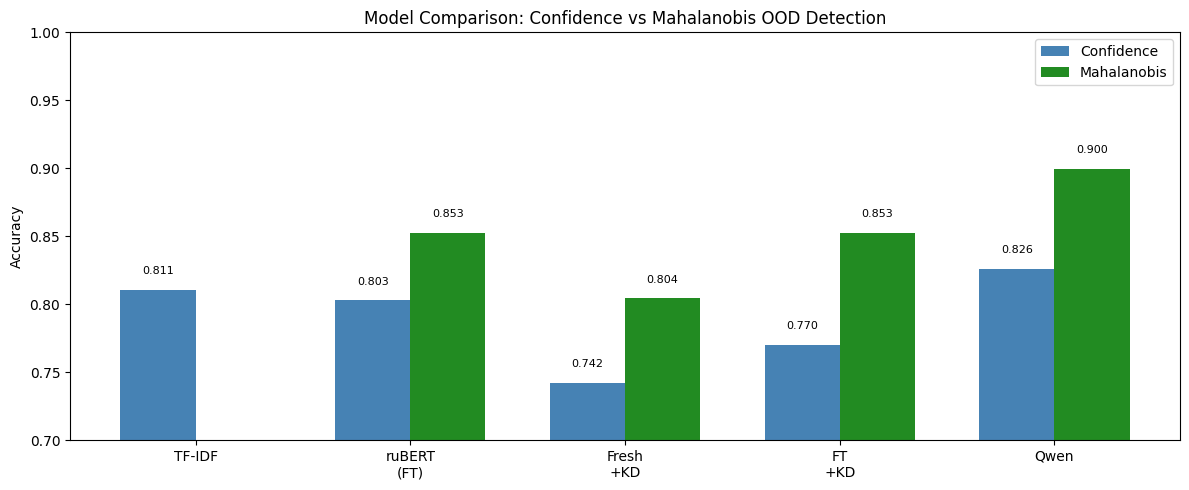


Saved best distilled model: ./distilled_rubert


In [34]:
# === FINAL COMPARISON: All Models × All Methods ===

best_student = student_fresh if hist_fresh['acc'][-1] > hist_finetuned['acc'][-1] else bert_model_ft

print("\n" + "="*70)
print("FINAL RESULTS: ALL MODELS × OOD METHODS")
print("="*70)
print(f"{'Model':<25} {'Confidence':<12} {'Mahalanobis':<12} {'Best':<12}")
print("-"*70)
print(f"{'TF-IDF + LogReg':<25} {tfidf_acc_thresh:<12.4f} {'—':<12} {tfidf_acc_thresh:<12.4f}")
print(f"{'ruBERT-tiny (FT)':<25} {bert_acc_thresh:<12.4f} {bert_maha_acc:<12.4f} {max(bert_acc_thresh, bert_maha_acc):<12.4f}")
print(f"{'Fresh BERT + KD':<25} {hist_fresh['acc'][-1]:<12.4f} {fresh_maha_acc:<12.4f} {max(hist_fresh['acc'][-1], fresh_maha_acc):<12.4f}")
print(f"{'Fine-tuned BERT + KD':<25} {hist_finetuned['acc'][-1]:<12.4f} {ft_maha_acc:<12.4f} {max(hist_finetuned['acc'][-1], ft_maha_acc):<12.4f}")
print(f"{'Qwen Dual-Head':<25} {conf_acc:<12.4f} {maha_acc:<12.4f} {max(conf_acc, maha_acc):<12.4f}")
print("="*70)

# Best overall
all_results = [
    ("TF-IDF", tfidf_acc_thresh),
    ("ruBERT-tiny (Conf)", bert_acc_thresh),
    ("ruBERT-tiny (Maha)", bert_maha_acc),
    ("Fresh+KD (Conf)", hist_fresh['acc'][-1]),
    ("Fresh+KD (Maha)", fresh_maha_acc),
    ("FT+KD (Conf)", hist_finetuned['acc'][-1]),
    ("FT+KD (Maha)", ft_maha_acc),
    ("Qwen (Conf)", conf_acc),
    ("Qwen (Maha)", maha_acc),
]
best = max(all_results, key=lambda x: x[1])
print(f"\nBEST OVERALL: {best[0]} = {best[1]:.4f}")

# Bar chart comparison
fig, ax = plt.subplots(figsize=(12, 5))
models = ["TF-IDF", "ruBERT\n(FT)", "Fresh\n+KD", "FT\n+KD", "Qwen"]
conf_accs = [tfidf_acc_thresh, bert_acc_thresh, hist_fresh['acc'][-1], hist_finetuned['acc'][-1], conf_acc]
maha_accs = [0, bert_maha_acc, fresh_maha_acc, ft_maha_acc, maha_acc]

x = np.arange(len(models))
width = 0.35
bars1 = ax.bar(x - width/2, conf_accs, width, label='Confidence', color='steelblue')
bars2 = ax.bar(x + width/2, maha_accs, width, label='Mahalanobis', color='forestgreen')

ax.set_ylabel('Accuracy')
ax.set_title('Model Comparison: Confidence vs Mahalanobis OOD Detection')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0.7, 1.0)

for bars in [bars1, bars2]:
    for bar in bars:
        if bar.get_height() > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{bar.get_height():.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig("final_comparison.png", dpi=150)
plt.show()

# Save best distilled model
best_student.save_pretrained("distilled_rubert")
bert_tokenizer.save_pretrained("distilled_rubert")
print(f"\nSaved best distilled model: ./distilled_rubert")